# Home Price Prediction Machine Learning Model (using BHI data)

Predict home price based on location, brand, square footage, number of bedrooms, number of batchrooms, garage size, and number of stories.  Predictions can then be compared to the actual home price to determine which homes are over and underpriced in their respective markets.  This model can also be used to help determine a price for a new home or exisitng home before it is put on the market.

This notebook demonstrates the following capabilities:

* Reads in CSV data which includes two very large catigory columns which are processed using embedding rather than one hot encoding.
* Encodes category/enumerations putting them in the format needed for training the model.  These include both ordered and unordered categories.
* Trains the model showing a plot of convergence rate allowing for easy adjustment of the learning rate, epochs, and hidden size for best training efficiency and final accuracy.
* Saves the trained model to disk, and later loads back in that model for price predictions.
* Calculates and displays final model accuracy percentage.
* Scatter plots all home actual vs predicted prices as another method of displaying final model accuracy.
* Plots line overlay of all home actual vs predicted prices helping show visually stocks that deviate most from the model’s prediction.
    * This plot is shown twice; once to help show overpriced homes, and once to help show underpriced homes
* Outputs a spreadsheet showing homes including all metrics used to predict the price, both the actual and predicted price, and the percentage difference between those prices denoting how much a home is either overpriced or underpriced.

A Mac M1 Pro using CPU takes around 58 seconds to train this model to a high level of accuracy (~93%).

In [65]:
# %pip install category_encoders
# %pip install graphviz
# conda install python-graphviz
# %pip install matplotlib
# %pip install numpy
# %pip install pandas
# %pip install sklearn
# %pip install torch
# %pip install torchviz

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchviz import make_dot

# We are defaulting to CPU, but you may want to compare CPU vs GPU performance
# device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu" # Use cpu since this dataset is too small to take advantage of the GPU

In [66]:
input_df = pd.read_csv('../inputs/home_sales.csv')
input_df = input_df.dropna()
input_df['BHIZip'] = input_df['BHIZip'].astype('str').str.rstrip('.0')
input_df.head()

,IndustryPlanID,BHIBrandName,BHIState,BHICity,BHIZip,PlanName,Bedrooms,Baths,BaseSqFt,Garage,Stories,BasePrice
0,17,Classic Homes,CO,Colorado Springs,80921,Dynasty,7,5,5154.0,3.0,2.0,883300.0
1,53,Saddlehorn,SC,Pelzer,29669,Williamsburg A,4,3,2915.0,2.0,2.0,524990.0
2,54,Neidhart Enterprises Inc.,AZ,Phoenix,85225,Geiger,4,4,4125.0,3.0,1.0,725000.0
3,55,Neidhart Enterprises Inc.,AZ,Phoenix,85225,Lamaide,3,2,2664.0,3.0,1.0,489000.0
4,56,Neidhart Enterprises Inc.,AZ,Phoenix,85225,Glaser,3,2,1919.0,1.0,1.0,479000.0


In [67]:
# Separate dataframe into features, and target.  
target_df = pd.DataFrame({'BasePrice': input_df['BasePrice']})
target_df['BasePrice'] = target_df['BasePrice']
# We do not use the PlanName, BHICity, or BHIState when training the features to predict the target
features_df = input_df.drop(['BasePrice', 'BHICity', 'BHIState', 'PlanName', 'IndustryPlanID'], axis=1)
# BHIBrandName and BHIZip are categories but too large to one hot encode them, so instead represent them as embeddings
features_df['BHIBrandName'] = pd.Categorical(features_df['BHIBrandName']) # Convert string to category
features_df['BHIZip'] = pd.Categorical(features_df['BHIZip']) # Convert string to category
num_brand_embeddings = len(features_df['BHIBrandName'].cat.categories)
num_zip_embeddings = len(features_df['BHIZip'].cat.categories)
num_in_features = 5 # Non-embedded features
# Create dictionaries for all embeddings that we can save with the model for use in other application that use the model
brand_dictionary = dict(enumerate(features_df['BHIBrandName'].cat.categories))
zip_dictionary = dict(enumerate(features_df['BHIZip'].cat.categories))
print(f'Number of unique brands = {num_brand_embeddings}')
print(f'Number of unique zip codes = {num_zip_embeddings}')
print(f'Number of additional input parameters = {num_in_features}')
print(f'Total input parameters (per home) = {num_brand_embeddings + num_zip_embeddings + num_in_features}')
features_df.head()

Number of unique brands = 456
Number of unique zip codes = 2381
Number of additional input parameters = 5
Total input parameters (per home) = 2842


,BHIBrandName,BHIZip,Bedrooms,Baths,BaseSqFt,Garage,Stories
0,Classic Homes,80921,7,5,5154.0,3.0,2.0
1,Saddlehorn,29669,4,3,2915.0,2.0,2.0
2,Neidhart Enterprises Inc.,85225,4,4,4125.0,3.0,1.0
3,Neidhart Enterprises Inc.,85225,3,2,2664.0,3.0,1.0
4,Neidhart Enterprises Inc.,85225,3,2,1919.0,1.0,1.0


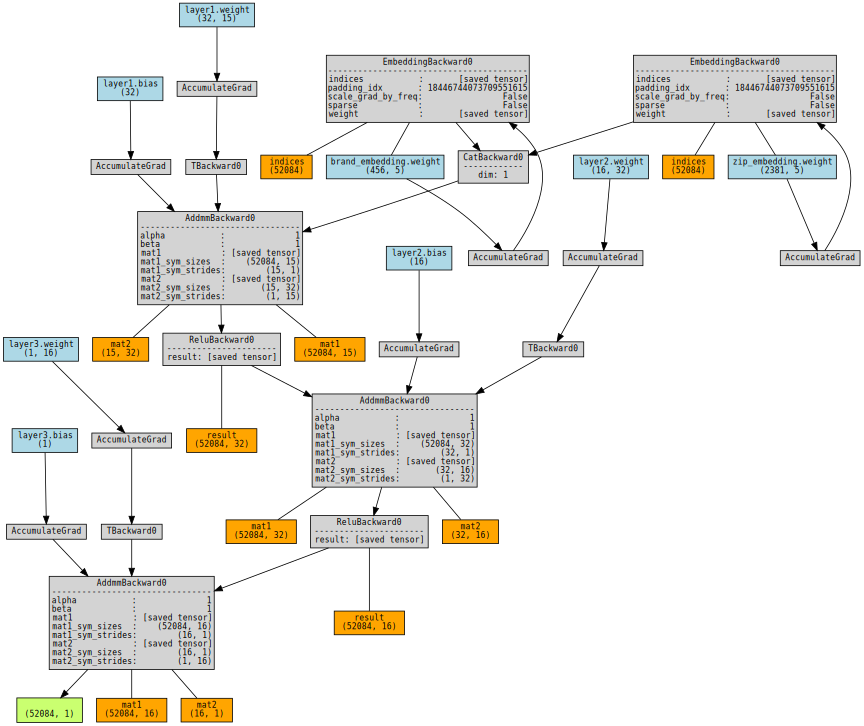

In [68]:
# Convert dataframes to dataset
class MyDataset(Dataset):
    def __init__(self, input_df, target_df):
        self.brand_tensor = torch.tensor(input_df['BHIBrandName'].cat.codes.values, dtype=torch.long).to(device)
        self.zip_tensor = torch.tensor(input_df['BHIZip'].cat.codes.values, dtype=torch.long).to(device)
        self.input_tensor = torch.tensor(input_df[['Bedrooms', 'Baths', 'BaseSqFt', 'Garage', 'Stories']].values, dtype=torch.float32).to(device)
        self.target_tensor = torch.tensor(target_df.values, dtype=torch.float32).to(device)
    def __len__(self):
        return len(self.input_tensor) # Number of rows in our input dataset
    def __getitem__(self, idx):
        return self.brand_tensor[idx], self.zip_tensor[idx], self.input_tensor[idx], self.target_tensor[idx]
    def get_tensors(self):
        return self.brand_tensor, self.zip_tensor, self.input_tensor, self.target_tensor

# Define PyTorch model
class MyModel(nn.Module):
    def __init__(self, in_features, num_brand_embeddings, num_zip_embeddings, brand_dictionary, zip_dictionary):
        super(MyModel, self).__init__()
        embedding_dim = 5 # Size of each embedding vector (tunable during training)
        hidden_dim = 16 # Dimensions used for the inner layers of the model
        self.brand_dictionary = brand_dictionary
        self.zip_dictionary = zip_dictionary
        self.brand_embedding = nn.Embedding(num_brand_embeddings, embedding_dim)
        self.zip_embedding = nn.Embedding(num_zip_embeddings, embedding_dim)
        in_features = embedding_dim*2 + in_features
        self.layer1 = nn.Linear(in_features, hidden_dim*2)
        self.layer2 = nn.Linear(hidden_dim*2, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, 1)
        
    def forward(self, brand_tensor, zip_tensor, input_tensor):
        brand_tensor = self.brand_embedding(brand_tensor)
        zip_tensor = self.zip_embedding(zip_tensor)
        # Concat all tensors after creating embedding vectors, then pass them into the first layer
        x = torch.cat([brand_tensor, zip_tensor, input_tensor], dim=1)
        x = nn.functional.relu(self.layer1(x))
        x = nn.functional.relu(self.layer2(x))
        x = self.layer3(x)
        return x

dataset = MyDataset(features_df, target_df)
model = model = MyModel(num_in_features, num_brand_embeddings, num_zip_embeddings, brand_dictionary, zip_dictionary).to(device)
brand_train_tensor, zip_train_tensor, x_train_tensor, target_tensor = dataset.get_tensors()
make_dot(model(brand_train_tensor, zip_train_tensor, x_train_tensor), params=dict(model.named_parameters()), show_attrs=True, show_saved=True)

In [69]:
# Training Tuning Parameters
# Start with 500 epochs, 0.00001 learn rate, and 3 layers each with a hidden_dim of 300
batch_size = 64
learning_rate = 0.01
num_epochs = 100
# Choose the best loss and optimizer functions
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Split the data and setup the data loaders
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
print(f'Training Size = {train_size}')
print(f'Test Size = {test_size}')

Training Size = 41667
Test Size = 10417


Epoch 5 (5%), Loss: 49869472
Epoch 10 (10%), Loss: 16123770
Epoch 15 (15%), Loss: 8773265
Epoch 20 (20%), Loss: 5969189
Epoch 25 (25%), Loss: 4513073
Epoch 30 (30%), Loss: 3706456
Epoch 35 (35%), Loss: 2797160
Epoch 40 (40%), Loss: 2691827
Epoch 45 (45%), Loss: 2171615
Epoch 50 (50%), Loss: 1989947
Epoch 55 (55%), Loss: 1639477
Epoch 60 (60%), Loss: 1575932
Epoch 65 (65%), Loss: 1305299
Epoch 70 (70%), Loss: 1188730
Epoch 75 (75%), Loss: 1074185
Epoch 80 (80%), Loss: 996724
Epoch 85 (85%), Loss: 941383
Epoch 90 (90%), Loss: 883957
Epoch 95 (95%), Loss: 823915
Epoch 100 (100%), Loss: 750549


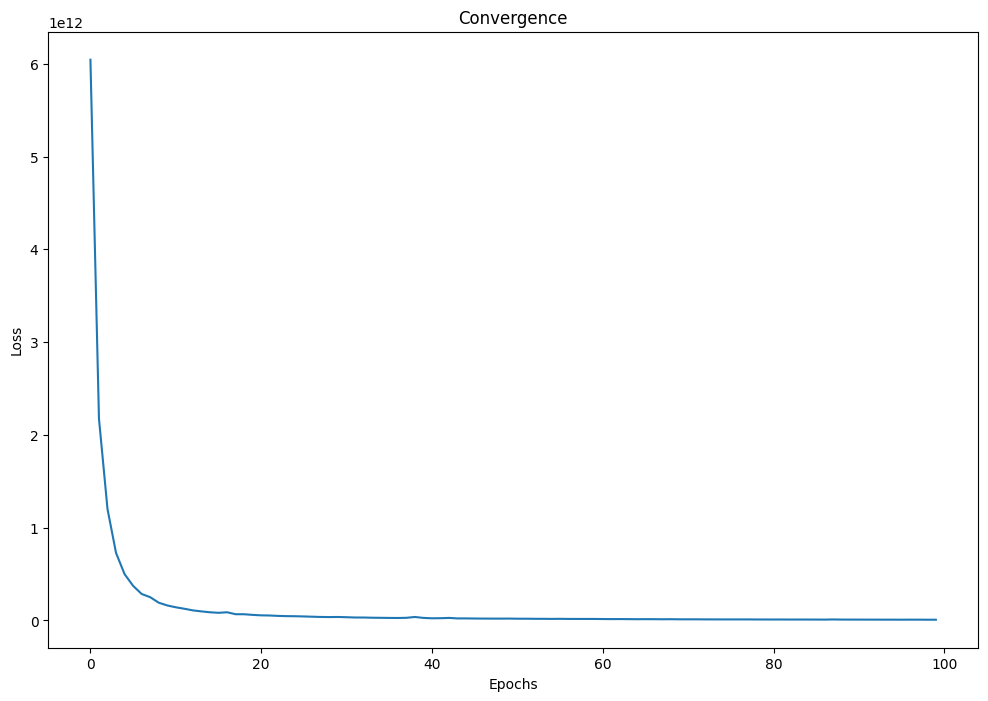

In [70]:
# Train the model and plot convergence
def train(train_dataloader, test_dataloader, model, criterion, optimizer, num_epochs):
    plot_losses = []
    for epoch in range(1, num_epochs+1):
        total_loss = 0.0
        model.train()
        for i, data in enumerate(train_dataloader, 0):
            brand_tensor, zip_tensor, input_tensor, target_tensor = data
            optimizer.zero_grad()
            output_tensor = model(brand_tensor, zip_tensor, input_tensor)
            loss = criterion(output_tensor, target_tensor)
            loss.backward()
            optimizer.step()
        model.eval()
        with torch.no_grad():
            for i, data in enumerate(test_dataloader, 0):
                brand_tensor, zip_tensor, input_tensor, target_tensor = data
                output_tensor = model(brand_tensor, zip_tensor, input_tensor)
                loss = criterion(output_tensor, target_tensor)
                total_loss += loss.item()
        if epoch % (num_epochs/20) == 0:
            percentComplete = epoch/num_epochs*100
            print(f'Epoch {epoch} ({percentComplete:.0f}%), Loss: {total_loss/epoch/10000:.0f}') # /100 to simplify display only
        plot_losses.append(total_loss/epoch)
    return plot_losses

# Train the model and plot convergence
plot_losses = train(train_dataloader, test_dataloader, model, criterion, optimizer, num_epochs)
fig, ax = plt.subplots(figsize=(12, 8))
plt.title("Convergence")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(plot_losses)

In [71]:
# Save model to file
path = '../api/home_price_model.pth'
torch.save(model, path)
saved_model = torch.load(path)

def getAccuracyPercentage(list1, list2):
    mean_abs_diff = np.mean(np.abs(list1 - list2))
    mean_orig = np.mean([list1, list2])
    return 100 - mean_abs_diff / mean_orig * 100

# Test the model's accuracy
saved_model.eval()
brand_tensor, zip_tensor, input_tensor, target_tensor = test_dataset.dataset.get_tensors()
with torch.no_grad():
    y_prediction_tensor = saved_model(brand_tensor, zip_tensor, input_tensor)
    y_predicted = y_prediction_tensor.detach().cpu().numpy()
    y_actual = target_tensor.detach().cpu().numpy()
    accuracy_percent = getAccuracyPercentage(y_predicted, y_actual)
    print(f"Test Accuracy: {accuracy_percent:>0.1f}%")

Test Accuracy: 93.7%


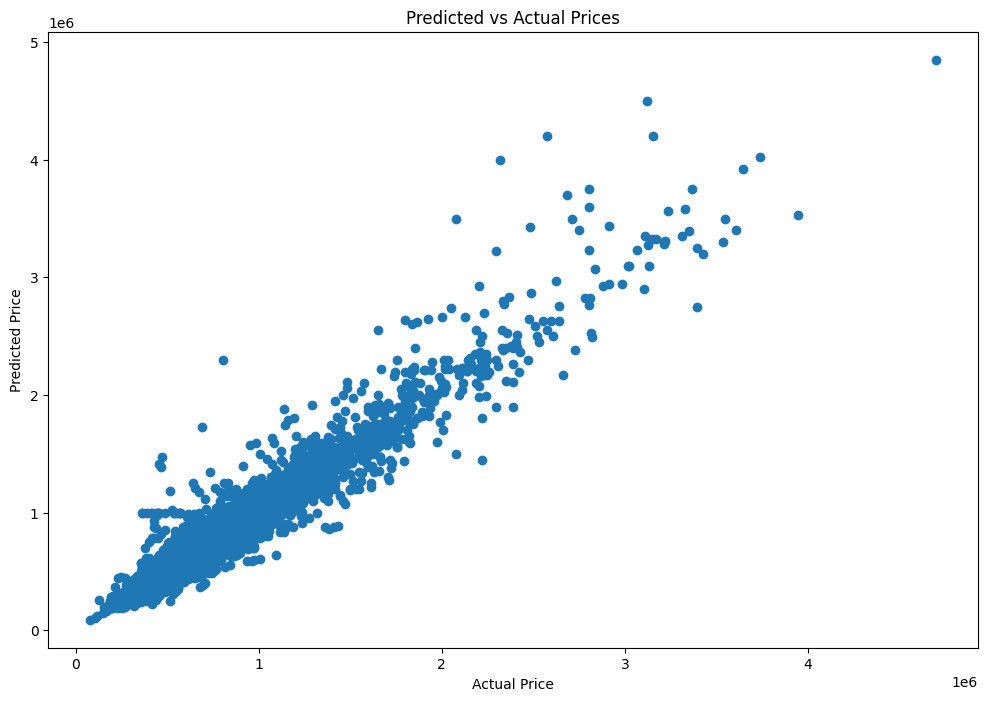

In [72]:
# Scatter plot results to show accuracy (45% upward, rightward slope scatter plot)
plt.figure(figsize=(12,8))
plt.scatter(y_predicted, y_actual)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Prices")
plt.show()

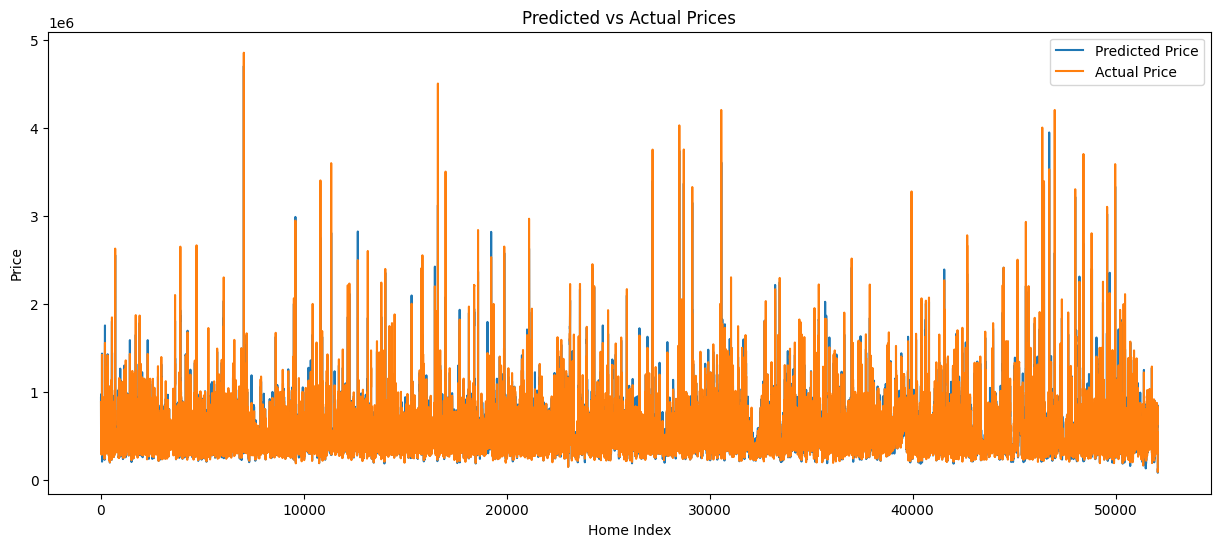

In [73]:
# Show accuracy by overlaying actual vs pridicted prices
# Orange on top helps underpriced stocks stand out
plt.figure(figsize=(15,6))
plt.plot(y_predicted, color='#1f77b4', label='Predicted Price')
plt.plot(y_actual, color='#ff7f0e', label='Actual Price')
plt.title("Predicted vs Actual Prices")
plt.xlabel("Home Index")
plt.ylabel("Price")
plt.legend()
plt.show()

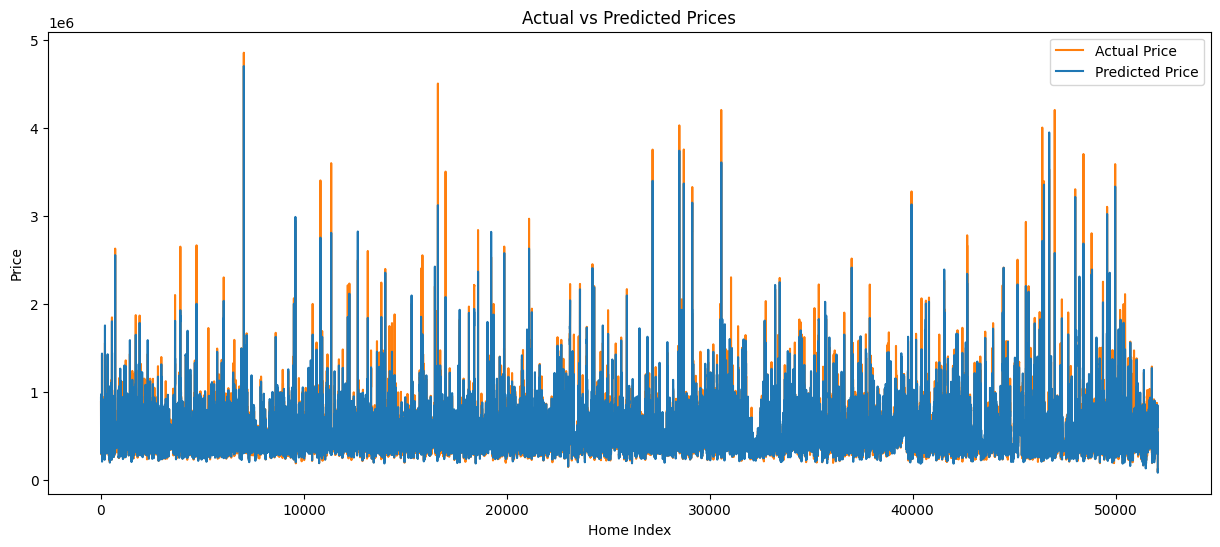

In [74]:
# Inverse the plot so blue is on top.  This helps high overpriced homes stand out
plt.figure(figsize=(15,6))
plt.plot(y_actual, color='#ff7f0e', label='Actual Price')
plt.plot(y_predicted, color='#1f77b4', label='Predicted Price')
plt.title("Actual vs Predicted Prices")
plt.xlabel("Home Index")
plt.ylabel("Price")
plt.legend()
plt.show()

In [75]:
# Run predictions for the full dataset
saved_model.eval()
brand_tensor, zip_tensor, input_tensor, target_tensor = test_dataset.dataset.get_tensors()
with torch.no_grad():
    y_prediction_tensor = saved_model(brand_tensor, zip_tensor, input_tensor)
    y_predicted = y_prediction_tensor.detach().cpu().numpy()
    y_actual = target_tensor.detach().cpu().numpy()
    predicted_price_difference = (y_predicted - y_actual) / ((y_predicted + y_actual) / 2) * 100
    accuracy_percent = 100-abs(np.average(predicted_price_difference))
# Generate and save to disk a new table with both actual and predicted prices for just those stocks where the prices differ by over 10%
output_df = input_df.copy()
output_df['Predicted Price'] = y_predicted.round()
output_df['% Difference'] = predicted_price_difference
output_df.to_csv('../outputs/home_price.csv', index=False)
# Sort so the prices that are too low go to the top
output_df = output_df.sort_values(by='% Difference', ascending=False)
# Homes selling too low
output_df.sample(10, ignore_index=True)

,IndustryPlanID,BHIBrandName,BHIState,BHICity,BHIZip,PlanName,Bedrooms,Baths,BaseSqFt,Garage,Stories,BasePrice,Predicted Price,% Difference
0,301562,Richmond American Homes,CA,Folsom,9563,Avalon,2,2,1945.0,2.0,1.0,609950.0,651054.0,6.519250
1,359212,Highland Homes,TX,Conroe,77302,Plan Portofino,3,2,1605.0,2.0,1.0,311990.0,318366.0,2.023033
2,340815,Homes By Taber,OK,Edmond,73134,Zade Bonus Room,4,3,2850.0,3.0,2.0,526840.0,519929.0,-1.320426
3,353616,Brohn Homes,TX,Elgin,78621,Harvest Ridge 1320,2,2,1320.0,2.0,1.0,299990.0,306656.0,2.197525
4,313094,Lennar,NJ,Monroe Township,8831,Capri,3,3,2731.0,2.0,2.0,764990.0,739070.0,-3.446603
5,333595,Classic Homes,CO,Monument,80132,Grand Mesa,7,5,5221.0,4.0,2.0,918000.0,891630.0,-2.914464
6,364251,Allen Edwin Homes,MI,Mattawan,49071,Elements 1800,3,2,1805.0,2.0,1.0,300900.0,314591.0,4.448737
7,281693,Ashton Woods,TX,Fresno,77459,Hamilton,4,3,1861.0,2.0,1.0,345990.0,361369.0,4.348391
8,380446,Lennar,FL,Ocala,34479,TREVI,4,3,2028.0,0.0,1.0,999999.0,964944.0,-3.568036
9,307080,Gehan Homes,TX,Royse City,75189,Landmark Series - Southfork,4,2,2380.0,2.0,2.0,344990.0,370715.0,7.188750
